In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond
# 
# In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df
# 
# For more reinforcment learning tutorials, see:
# https://github.com/awjuliani/DeepRL-Agents

# In[1]:


from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline
#get_ipython().run_line_magic('matplotlib', 'inline')


# ### Load the game environment

# Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

# In[2]:




C:\Users\Assistant_2\Anaconda3\envs\RL_test\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Assistant_2\Anaconda3\envs\RL_test\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Assistant_2\Anaconda3\envs\RL_test\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Assistant_2\Anaconda3\envs\RL_test\lib\s

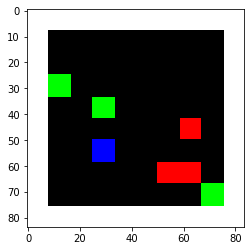

In [28]:
from gridworld_gaussian import gameEnv

env = gameEnv(partial=False,size=8)

In [3]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [5]:
def processState(states):
    return np.reshape(states,[21168])

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [7]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./DQN_gaussian" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Instructions for updating:
Use keras.layers.flatten instead.


Saved Model
500 0.7 1
1000 -1.4 1
1500 -0.4 1
2000 0.1 1
2500 -0.1 1
3000 0.5 1
3500 0.6 1
4000 -1.0 1
4500 -0.1 1
5000 -0.3 1
5500 0.8 1
6000 -1.1 1
6500 -0.7 1
7000 -0.3 1
7500 -0.1 1
8000 -0.1 1
8500 -0.3 1
9000 -1.0 1
9500 -0.1 1
10000 0.3 1
10500 0.0 0.9549999999999828
11000 0.4 0.9099999999999655
11500 0.1 0.8649999999999483
12000 0.7 0.819999999999931
12500 0.6 0.7749999999999138
13000 -0.5 0.7299999999998965
13500 -0.3 0.6849999999998793
14000 -0.2 0.639999999999862
14500 -0.6 0.5949999999998448
15000 0.5 0.5499999999998275
15500 0.7 0.5049999999998103
16000 -0.3 0.4599999999998177
16500 0.3 0.41499999999982823
17000 -0.1 0.36999999999983874
17500 0.9 0.32499999999984924
18000 0.5 0.27999999999985975
18500 -0.1 0.23499999999986562
19000 0.2 0.18999999999986225
19500 0.0 0.14499999999985888
20000 0.4 0.09999999999985551
20500 0.1 0.09999999999985551
21000 0.6 0.09999999999985551
21500 0.0 0.09999999999985551
22000 0.5 0.09999999999985551
22500 0.4 0.09999999999985551
23000 0.5 0

83000 1.6 0.09999999999985551
83500 2.3 0.09999999999985551
84000 3.8 0.09999999999985551
84500 3.4 0.09999999999985551
85000 2.9 0.09999999999985551
85500 2.6 0.09999999999985551
86000 3.0 0.09999999999985551
86500 2.4 0.09999999999985551
87000 3.2 0.09999999999985551
87500 1.2 0.09999999999985551
88000 3.5 0.09999999999985551
88500 3.1 0.09999999999985551
89000 1.9 0.09999999999985551
89500 2.4 0.09999999999985551
90000 2.5 0.09999999999985551
90500 2.0 0.09999999999985551
91000 3.5 0.09999999999985551
91500 2.4 0.09999999999985551
92000 5.1 0.09999999999985551
92500 3.0 0.09999999999985551
93000 3.8 0.09999999999985551
93500 3.4 0.09999999999985551
94000 4.1 0.09999999999985551
94500 1.4 0.09999999999985551
95000 3.2 0.09999999999985551
95500 4.2 0.09999999999985551
96000 4.0 0.09999999999985551
96500 4.9 0.09999999999985551
97000 2.6 0.09999999999985551
97500 3.5 0.09999999999985551
98000 4.7 0.09999999999985551
98500 2.8 0.09999999999985551
99000 4.0 0.09999999999985551
99500 3.9 

215000 8.4 0.09999999999985551
215500 10.4 0.09999999999985551
216000 9.4 0.09999999999985551
216500 9.8 0.09999999999985551
217000 8.3 0.09999999999985551
217500 9.3 0.09999999999985551
218000 8.1 0.09999999999985551
218500 9.6 0.09999999999985551
219000 9.0 0.09999999999985551
219500 7.4 0.09999999999985551
220000 8.9 0.09999999999985551
220500 8.9 0.09999999999985551
221000 9.6 0.09999999999985551
221500 8.7 0.09999999999985551
222000 8.6 0.09999999999985551
222500 8.1 0.09999999999985551
223000 10.2 0.09999999999985551
223500 5.9 0.09999999999985551
224000 7.6 0.09999999999985551
224500 8.1 0.09999999999985551
225000 6.1 0.09999999999985551
225500 8.3 0.09999999999985551
226000 9.7 0.09999999999985551
226500 7.8 0.09999999999985551
227000 5.8 0.09999999999985551
227500 8.4 0.09999999999985551
228000 7.6 0.09999999999985551
228500 7.8 0.09999999999985551
229000 7.5 0.09999999999985551
229500 9.4 0.09999999999985551
230000 8.7 0.09999999999985551
230500 9.0 0.09999999999985551
231000

340500 9.4 0.09999999999985551
341000 8.9 0.09999999999985551
341500 10.3 0.09999999999985551
342000 11.3 0.09999999999985551
342500 8.0 0.09999999999985551
343000 8.9 0.09999999999985551
343500 7.6 0.09999999999985551
344000 10.4 0.09999999999985551
344500 8.8 0.09999999999985551
345000 9.3 0.09999999999985551
345500 6.6 0.09999999999985551
346000 6.3 0.09999999999985551
346500 10.9 0.09999999999985551
347000 8.7 0.09999999999985551
347500 10.4 0.09999999999985551
348000 7.7 0.09999999999985551
348500 9.3 0.09999999999985551
349000 8.3 0.09999999999985551
349500 10.2 0.09999999999985551
350000 8.5 0.09999999999985551
Saved Model
350500 9.1 0.09999999999985551
351000 7.5 0.09999999999985551
351500 7.1 0.09999999999985551
352000 8.9 0.09999999999985551
352500 8.8 0.09999999999985551
353000 12.2 0.09999999999985551
353500 8.9 0.09999999999985551
354000 8.0 0.09999999999985551
354500 8.7 0.09999999999985551
355000 10.1 0.09999999999985551
355500 8.7 0.09999999999985551
356000 8.5 0.099999

470500 12.2 0.09999999999985551
471000 8.7 0.09999999999985551
471500 12.0 0.09999999999985551
472000 11.7 0.09999999999985551
472500 11.0 0.09999999999985551
473000 11.5 0.09999999999985551
473500 10.2 0.09999999999985551
474000 7.6 0.09999999999985551
474500 8.8 0.09999999999985551
475000 11.6 0.09999999999985551
475500 10.9 0.09999999999985551
476000 10.3 0.09999999999985551
476500 12.0 0.09999999999985551
477000 10.6 0.09999999999985551
477500 8.5 0.09999999999985551
478000 9.5 0.09999999999985551
478500 9.4 0.09999999999985551
479000 8.8 0.09999999999985551
479500 9.3 0.09999999999985551
480000 10.9 0.09999999999985551
480500 10.1 0.09999999999985551
481000 13.0 0.09999999999985551
481500 10.8 0.09999999999985551
482000 10.6 0.09999999999985551
482500 11.0 0.09999999999985551
483000 10.9 0.09999999999985551
483500 9.7 0.09999999999985551
484000 11.0 0.09999999999985551
484500 10.8 0.09999999999985551
485000 11.1 0.09999999999985551
485500 11.4 0.09999999999985551
486000 8.1 0.0999

In [9]:
rList_gaussian = rList

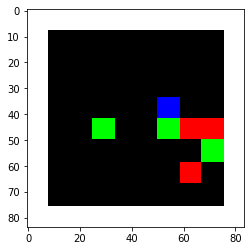

In [10]:
# random 환경 시작
from gridworld_random import gameEnv

env = gameEnv(partial=False,size=8)

In [11]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [12]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [13]:
def processState(states):
    return np.reshape(states,[21168])

In [14]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [15]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./DQN_random" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [16]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
500 -1.7 1
1000 0.1 1
1500 0.3 1
2000 -0.5 1
2500 -0.5 1
3000 0.4 1
3500 0.0 1
4000 -0.2 1
4500 -0.5 1
5000 0.9 1
5500 0.3 1
6000 1.5 1
6500 -0.5 1
7000 0.7 1
7500 1.6 1
8000 0.6 1
8500 0.4 1
9000 0.8 1
9500 0.0 1
10000 1.2 1
10500 -0.9 0.9549999999999828
11000 0.6 0.9099999999999655
11500 0.4 0.8649999999999483
12000 -1.2 0.819999999999931
12500 0.4 0.7749999999999138
13000 0.1 0.7299999999998965
13500 0.7 0.6849999999998793
14000 -0.6 0.639999999999862
14500 0.7 0.5949999999998448
15000 0.3 0.5499999999998275
15500 0.7 0.5049999999998103
16000 -0.3 0.4599999999998177
16500 0.4 0.41499999999982823
17000 0.2 0.36999999999983874
17500 -0.7 0.32499999999984924
18000 0.0 0.27999999999985975
18500 -0.1 0.23499999999986562
19000 0.8 0.18999999999986225
19500 0.0 0.14499999999985888
20000 0.9 0.09999999999985551
20500 0.2 0.09999999999985551
21000 0.4 0.09999999999985551
21500 -0.1 0.09999999999985551
22000 0.3 0.09999999999985551
22500 0.3 0.09999999999985551
23000 0.7 0.0999999

83000 4.1 0.09999999999985551
83500 5.7 0.09999999999985551
84000 4.6 0.09999999999985551
84500 4.9 0.09999999999985551
85000 4.4 0.09999999999985551
85500 4.1 0.09999999999985551
86000 4.9 0.09999999999985551
86500 6.8 0.09999999999985551
87000 7.9 0.09999999999985551
87500 5.7 0.09999999999985551
88000 7.3 0.09999999999985551
88500 8.8 0.09999999999985551
89000 3.5 0.09999999999985551
89500 8.0 0.09999999999985551
90000 7.0 0.09999999999985551
90500 7.1 0.09999999999985551
91000 6.9 0.09999999999985551
91500 8.2 0.09999999999985551
92000 7.1 0.09999999999985551
92500 6.5 0.09999999999985551
93000 6.0 0.09999999999985551
93500 4.8 0.09999999999985551
94000 3.8 0.09999999999985551
94500 9.4 0.09999999999985551
95000 5.4 0.09999999999985551
95500 7.7 0.09999999999985551
96000 8.3 0.09999999999985551
96500 8.2 0.09999999999985551
97000 6.4 0.09999999999985551
97500 7.6 0.09999999999985551
98000 6.4 0.09999999999985551
98500 8.9 0.09999999999985551
99000 5.1 0.09999999999985551
99500 11.7

213500 12.6 0.09999999999985551
214000 11.0 0.09999999999985551
214500 12.7 0.09999999999985551
215000 8.7 0.09999999999985551
215500 10.4 0.09999999999985551
216000 7.1 0.09999999999985551
216500 10.2 0.09999999999985551
217000 9.0 0.09999999999985551
217500 8.9 0.09999999999985551
218000 11.3 0.09999999999985551
218500 8.7 0.09999999999985551
219000 9.7 0.09999999999985551
219500 11.1 0.09999999999985551
220000 12.9 0.09999999999985551
220500 12.2 0.09999999999985551
221000 8.7 0.09999999999985551
221500 11.3 0.09999999999985551
222000 9.3 0.09999999999985551
222500 11.4 0.09999999999985551
223000 8.4 0.09999999999985551
223500 8.6 0.09999999999985551
224000 6.7 0.09999999999985551
224500 9.1 0.09999999999985551
225000 10.2 0.09999999999985551
225500 11.8 0.09999999999985551
226000 10.1 0.09999999999985551
226500 12.0 0.09999999999985551
227000 7.5 0.09999999999985551
227500 12.7 0.09999999999985551
228000 10.8 0.09999999999985551
228500 9.8 0.09999999999985551
229000 11.5 0.09999999

343000 12.4 0.09999999999985551
343500 10.6 0.09999999999985551
344000 8.5 0.09999999999985551
344500 10.2 0.09999999999985551
345000 13.1 0.09999999999985551
345500 11.1 0.09999999999985551
346000 12.3 0.09999999999985551
346500 8.4 0.09999999999985551
347000 12.6 0.09999999999985551
347500 12.3 0.09999999999985551
348000 12.4 0.09999999999985551
348500 9.8 0.09999999999985551
349000 8.7 0.09999999999985551
349500 12.2 0.09999999999985551
350000 14.6 0.09999999999985551
Saved Model
350500 13.3 0.09999999999985551
351000 9.4 0.09999999999985551
351500 11.2 0.09999999999985551
352000 8.6 0.09999999999985551
352500 11.9 0.09999999999985551
353000 12.1 0.09999999999985551
353500 12.5 0.09999999999985551
354000 8.3 0.09999999999985551
354500 15.2 0.09999999999985551
355000 10.0 0.09999999999985551
355500 8.2 0.09999999999985551
356000 10.9 0.09999999999985551
356500 12.4 0.09999999999985551
357000 10.4 0.09999999999985551
357500 15.1 0.09999999999985551
358000 11.0 0.09999999999985551
3585

471500 9.8 0.09999999999985551
472000 12.1 0.09999999999985551
472500 10.6 0.09999999999985551
473000 12.5 0.09999999999985551
473500 13.3 0.09999999999985551
474000 10.7 0.09999999999985551
474500 12.1 0.09999999999985551
475000 15.9 0.09999999999985551
475500 11.5 0.09999999999985551
476000 13.3 0.09999999999985551
476500 13.9 0.09999999999985551
477000 9.9 0.09999999999985551
477500 12.0 0.09999999999985551
478000 12.3 0.09999999999985551
478500 11.4 0.09999999999985551
479000 10.8 0.09999999999985551
479500 15.1 0.09999999999985551
480000 13.7 0.09999999999985551
480500 13.2 0.09999999999985551
481000 14.4 0.09999999999985551
481500 10.5 0.09999999999985551
482000 10.8 0.09999999999985551
482500 14.1 0.09999999999985551
483000 13.1 0.09999999999985551
483500 12.4 0.09999999999985551
484000 6.7 0.09999999999985551
484500 12.9 0.09999999999985551
485000 11.2 0.09999999999985551
485500 6.5 0.09999999999985551
486000 12.6 0.09999999999985551
486500 11.0 0.09999999999985551
487000 13.1 

In [17]:
rList_random = rList

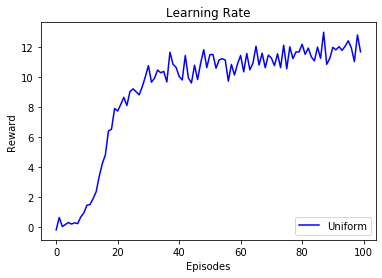

In [26]:
rMat_gaussian = np.resize(np.array(rList_gaussian),[len(rList_gaussian)//100,100])
rMean_gaussian = np.average(rMat_gaussian,1)
rMat_random = np.resize(np.array(rList_random),[len(rList_random)//100,100])
rMean_random = np.average(rMat_random,1)

#plt.plot(rMean_gaussian,'r', label = 'Gaussian')
plt.plot(rMean_random,'b', label = 'Uniform')
plt.title('Learning Rate')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend(loc = 'lower right')

plt.show()